<a href="https://colab.research.google.com/github/tristaylor/rockpaperscissor/blob/main/BNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---



# **Brain Tumor Classification**


---


This project trains on images of Brain MRI scans and then classifies each image into one of the following four categories:

*   Glioma Tumor
*   Meningioma Tumor
*   Pituitary Tumor
*   No Tumor


---



In [ ]:
!git clone https://github.com/tristaylor/BNET.git

Cloning into 'Brain-MRI-Classification'...
remote: Enumerating objects: 3125, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 3125 (delta 29), reused 75 (delta 23), pack-reused 3042
Receiving objects: 100% (3125/3125), 83.50 MiB | 18.12 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Updating files: 100% (3291/3291), done.


### Import libraries

In [ ]:
# Import libraries

import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils


### Create directories

In [ ]:
# Create Directory for Training Data

os.mkdir("/content/Crop-Brain-MRI")
os.mkdir("/content/Crop-Brain-MRI/glioma_tumor")
os.mkdir("/content/Crop-Brain-MRI/meningioma_tumor")
os.mkdir("/content/Crop-Brain-MRI/no_tumor")
os.mkdir("/content/Crop-Brain-MRI/pituitary_tumor")

In [ ]:
# Create Directory for Testing Data

os.mkdir("/content/Test-Brain-MRI")
os.mkdir("/content/Test-Brain-MRI/glioma_tumor")
os.mkdir("/content/Test-Brain-MRI/meningioma_tumor")
os.mkdir("/content/Test-Brain-MRI/no_tumor")
os.mkdir("/content/Test-Brain-MRI/pituitary_tumor")

### Data Visualisation

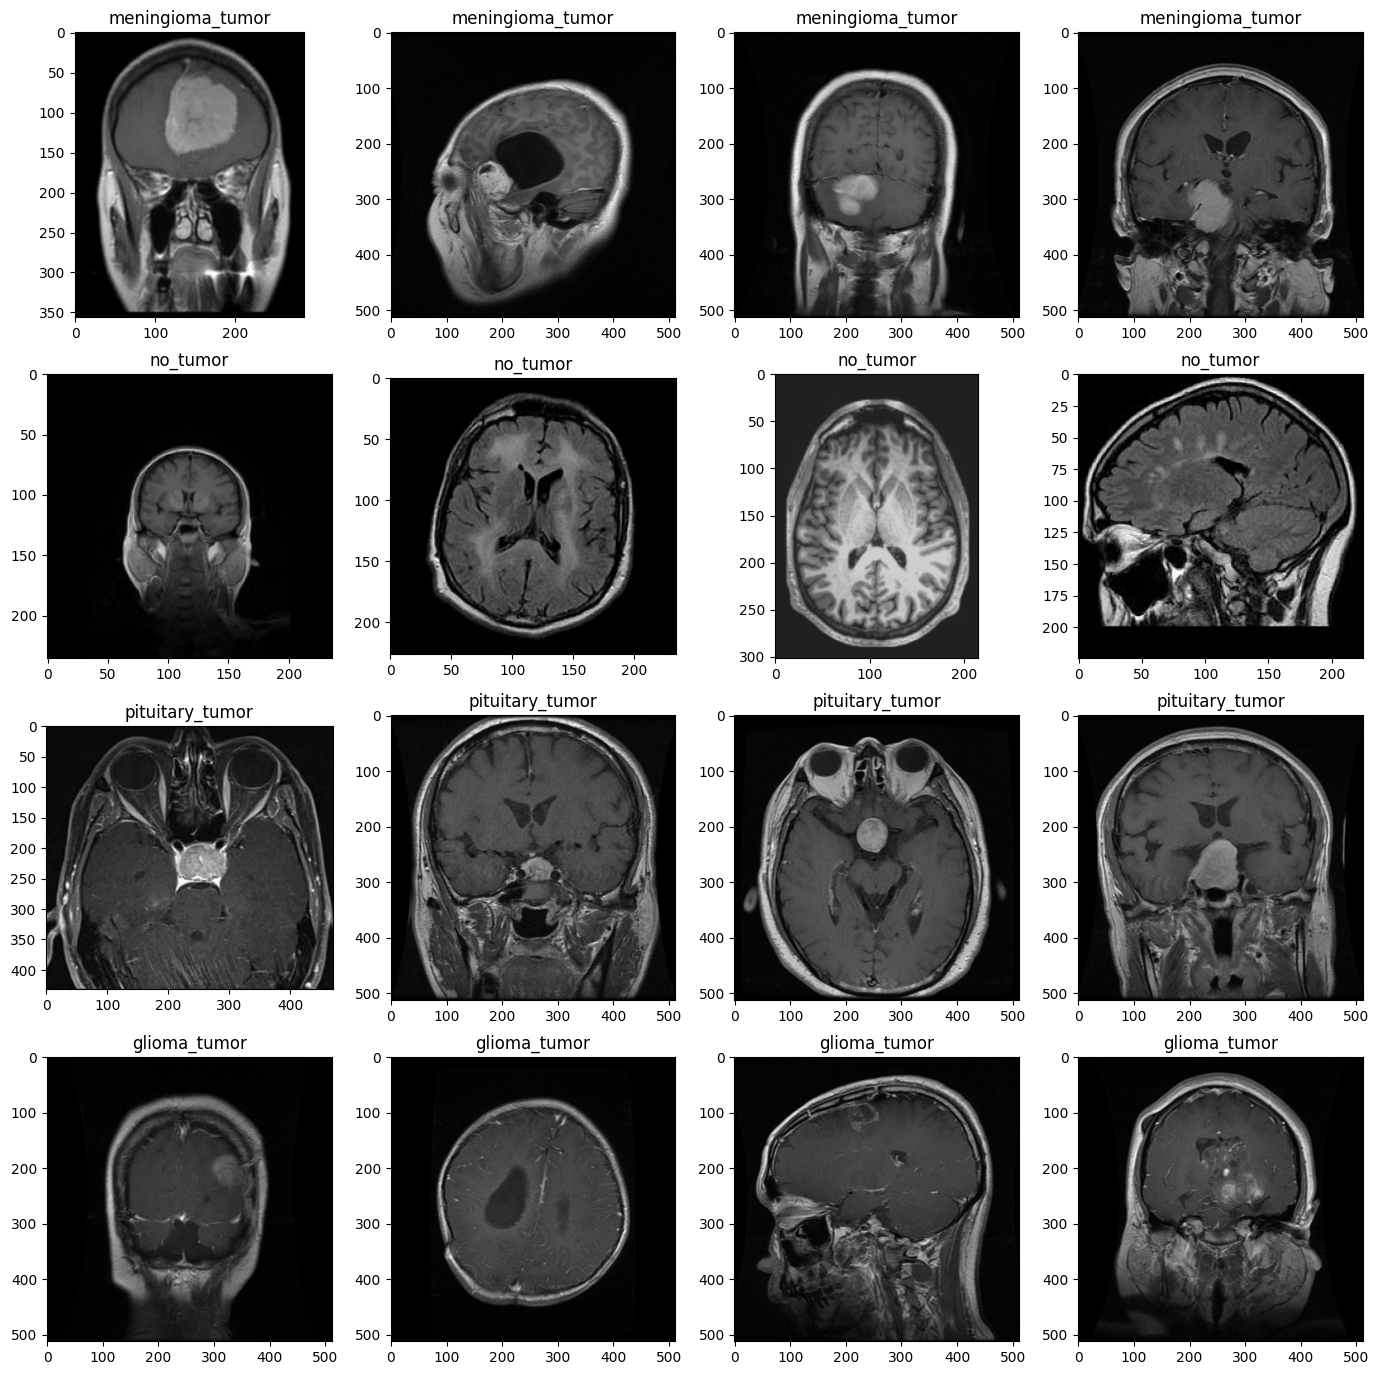

In [ ]:
# Data Visualisation

train_dir = "/content/Brain-MRI-Classification/Brain-MRI/Training/"
test_dir = "/content/Brain-MRI-Classification/Brain-MRI/Testing/"

classes = os.listdir("/content/Brain-MRI-Classification/Brain-MRI/Training")

files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x :train_dir+c+'/'+x, os.listdir(train_dir+c)))

plt.figure(figsize=(17,17))
index = 0

for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range (1,5):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

### Crop and Save images

In [ ]:
# Function to crop images

def crop_image(image, plot=False):

    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)

    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image


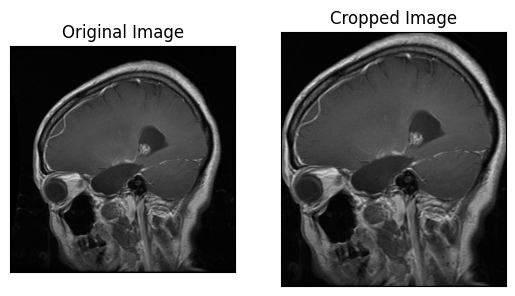

In [ ]:
# Check the crop

example_img = cv2.imread("/content/Brain-MRI-Classification/Brain-MRI/Training/glioma_tumor/gg (101).jpg")
cropped_image_example = crop_image(example_img, plot=True)

In [ ]:
# Crop the Training Images and Save to respective directories
glioma = train_dir + "glioma_tumor"
meningioma = train_dir + "meningioma_tumor"
no_tumor = train_dir + "no_tumor"
pituitary = train_dir + "pituitary_tumor"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/glioma_tumor/"+ str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/meningioma_tumor/" +str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Crop-Brain-MRI/no_tumor/"+str()+".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Crop-Brain-MRI/pituitary_tumor/"+str()+".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1





100%|██████████| 901/901 [00:10<00:00, 86.37it/s] 


In [ ]:
# Crop the Testing Images and Save to respective directories
glioma = test_dir + "glioma_tumor"
meningioma = test_dir + "meningioma_tumor"
no_tumor = test_dir + "no_tumor"
pituitary = test_dir + "pituitary_tumor"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-Brain-MRI/glioma_tumor/"+ str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-Brain-MRI/meningioma_tumor/" +str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Test-Brain-MRI/no_tumor/"+str()+".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Test-Brain-MRI/pituitary_tumor/"+str()+".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1





100%|██████████| 5/5 [00:00<00:00, 130.05it/s]


\### Perform Data Augmentation and Prepare the Train, Validation, and Test Dataset

In [ ]:
# Use Image Data Generator

datagen = ImageDataGenerator(rotation_range=10, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)
train_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/', target_size=(224,224), batch_size=32, class_mode='categorical', subset='training')

valid_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/', target_size=(224,224), batch_size=32, class_mode='categorical', subset='validation')

test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('/content/Test-Brain-MRI/', target_size=(224,224), class_mode='categorical')


Found 1493 images belonging to 4 classes.
Found 372 images belonging to 4 classes.
Found 12 images belonging to 4 classes.


In [ ]:
# View the class dictionary

print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


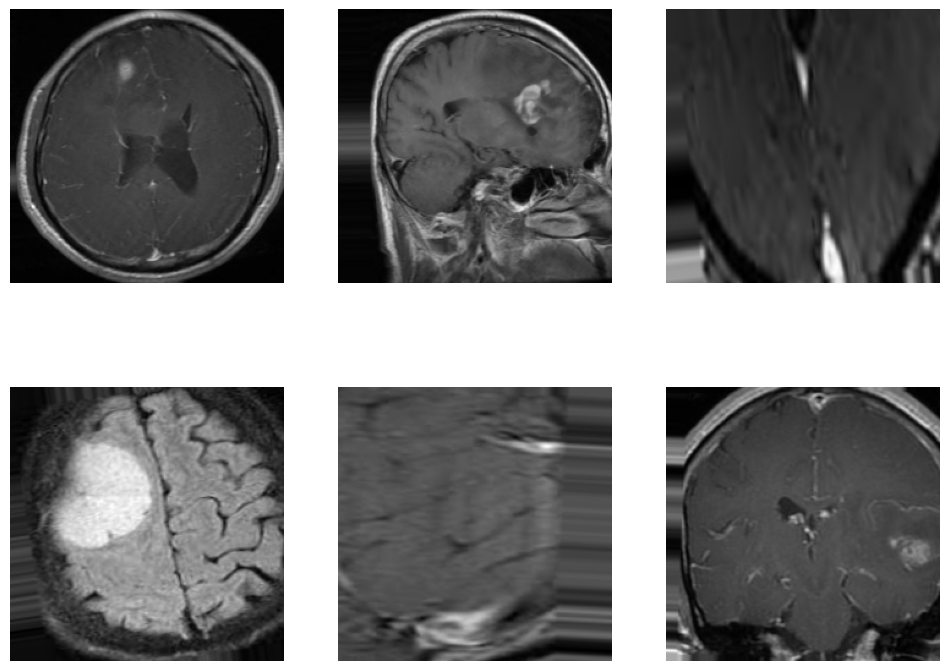

In [ ]:
# View the augmented data

sample_x, sample_y =next(train_data)
plt.figure(figsize=(12,9))
for i in range (6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()


### Build and Compile the model

In [ ]:
# Build the Model

effnet = EfficientNetB1(weights="imagenet", include_top=False, input_shape=(224,224, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= effnet.input, outputs=model)

model.summary()

27018416/27018416 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

In [ ]:
# Compile the model

model.compile(optimizer=Adam(lr=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto", verbose=1)

### Train and Evaluate the model

In [ ]:
# Train the model

history = model.fit(train_data, epochs=7, validation_data=valid_data, verbose=1, callbacks=[checkpoint, earlystop])


Epoch 1/7
47/47 [==============================] - ETA: 0s - loss: 0.4198 - accuracy: 0.8426
Epoch 1: val_accuracy improved from -inf to 0.91935, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 93s 740ms/step - loss: 0.4198 - accuracy: 0.8426 - val_loss: 0.3556 - val_accuracy: 0.9194
Epoch 2/7
47/47 [==============================] - ETA: 0s - loss: 0.1872 - accuracy: 0.9350
Epoch 2: val_accuracy improved from 0.91935 to 0.95968, saving model to model.h5
47/47 [==============================] - 32s 681ms/step - loss: 0.1872 - accuracy: 0.9350 - val_loss: 0.1308 - val_accuracy: 0.9597
Epoch 3/7
47/47 [==============================] - ETA: 0s - loss: 0.1305 - accuracy: 0.9545
Epoch 3: val_accuracy did not improve from 0.95968
47/47 [==============================] - 32s 677ms/step - loss: 0.1305 - accuracy: 0.9545 - val_loss: 0.2157 - val_accuracy: 0.9462
Epoch 4/7
47/47 [==============================] - ETA: 0s - loss: 0.1098 - accuracy: 0.9625
Epoch 4: val_accuracy did not improve from 0.95968
47/47 [==============================] - 30s 642ms/step - loss: 0.1098 - accuracy: 0.9625 - val_loss: 0.1978 - val_accuracy: 0.9382
Epoch 5/7


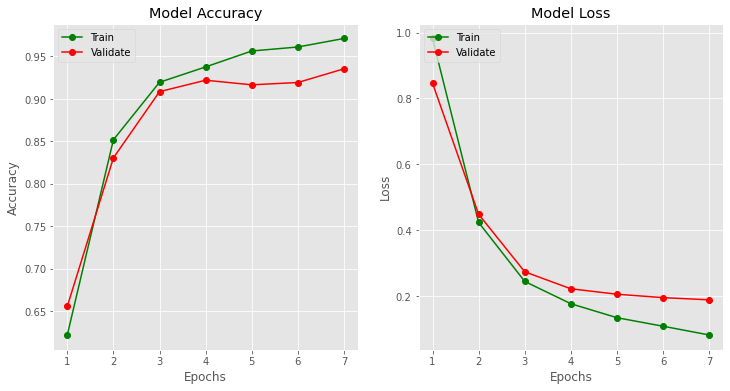

In [ ]:
# Plot the training curves

plt.style.use("ggplot")
plt.figure(figsize=(12,6))
epochs = range(1,8)
plt.subplot(1,2,1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","Validate"], loc="upper left")

plt.subplot(1,2,2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","Validate"], loc="upper left")

plt.show()

In [ ]:
# Evaluate the model on Test Set

model.evaluate(test_data)

1/1 [==============================] - 0s 191ms/step - loss: 0.7598 - accuracy: 0.7500


[0.7597576975822449, 0.75]

### Obtain Predictions

1/1 [==============================] - 0s 51ms/step
meningioma_tumor


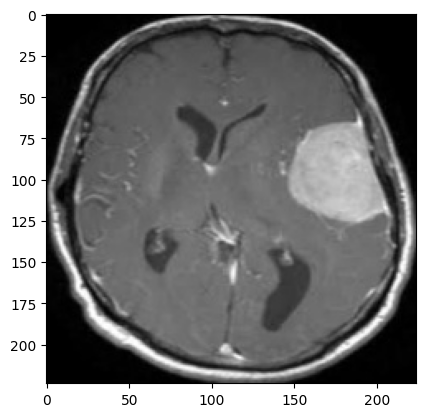

In [ ]:
# Obtain Prediction on Test Image

class_dict = {0: "glioma_tumor", 1: "meningioma_tumor", 2: "no_tumor", 3: "pituitary_tumor"}

test_img1 = cv2.imread("/content/Test-Brain-MRI/meningioma_tumor/2.jpg")

plt.imshow(test_img1)

plt.grid(False)

test_img1 = np.expand_dims(test_img1, axis=0)

pred = model.predict(test_img1)
pred = np.argmax(pred)
pred_class =class_dict[pred]
print(pred_class)

In [ ]:
#byeeeeeeee